In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.interpolate import griddata

## STATIC CASE

In [190]:
base_path = Path('../../data/raw')
# Read the data
df1 = pd.read_csv(base_path/'ft_optitrack_data_config_1.csv')
df2 = pd.read_csv(base_path/'ft_optitrack_data_config_2.csv')
df3 = pd.read_csv(base_path/'ft_optitrack_data_config_3.csv')
df4 = pd.read_csv(base_path/'data_static.csv')
# Create a dictionary with the column mappings
rename_dict = {
    'contact_x': 'ft_x',
    'contact_y': 'ft_y',
    'contact_z': 'ft_z',
    'position_x': 'opti_x',
    'position_y': 'opti_y',
    'position_z': 'opti_z',
    'force_x': 'ft_force_x',
    'force_y': 'ft_force_y',
    'force_z': 'ft_force_z'
}

for df in [df1, df2, df3, df4]:
    df.rename(columns=rename_dict, inplace=True)
    df.drop(df[(df['ft_x'] == 0) & (df['ft_y'] == 0)].index, inplace=True)


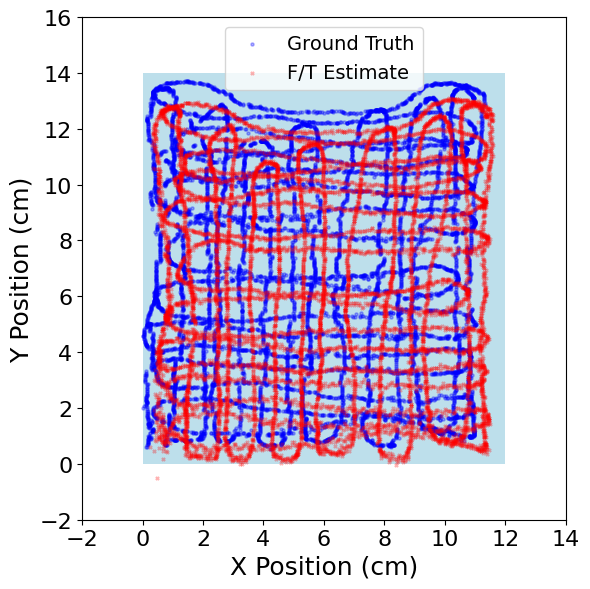

In [205]:
datasets = {'Config 1': df1, 'Config 2': df2, 'Config 3': df3, 'Config 4': df4}
colors = ['blue', 'red', 'green', 'purple']

# 1. Ground Truth vs Estimated Position Plots 
plt.figure(figsize=(6, 6))
# Add transparent blue rectangle for the pad (converted to cm)
pad = plt.Rectangle((0, 0), 12, 14, facecolor='lightblue', alpha=0.8)  # 0.12m -> 12cm, 0.14m -> 14cm
plt.gca().add_patch(pad)

# Convert positions to cm (multiply by 100)
plt.scatter(df1['opti_x']*100, df1['opti_y']*100, c='blue', label='Ground Truth', alpha=0.3, marker='o', s=5)
plt.scatter(df1['ft_x']*100, df1['ft_y']*100, c='red', label='F/T Estimate', alpha=0.3, marker='x', s=5)
plt.xlabel('X Position (cm)', fontsize=18)  # Increased font size
plt.ylabel('Y Position (cm)', fontsize=18)  # Increased font size
#plt.title('Contact Points: X-Y Plane')
plt.legend(fontsize=14)  # Increased legend font size
plt.grid(False)

# Set axis limits to ensure pad is visible (converted to cm)
plt.xlim(-2, 14)  # -0.02m -> -2cm, 0.14m -> 14cm
plt.ylim(-2, 16)  # -0.02m -> -2cm, 0.16m -> 16cm

# Increase tick label size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('../../img/contact_points.png', dpi=600, bbox_inches='tight', format='png')
plt.show()

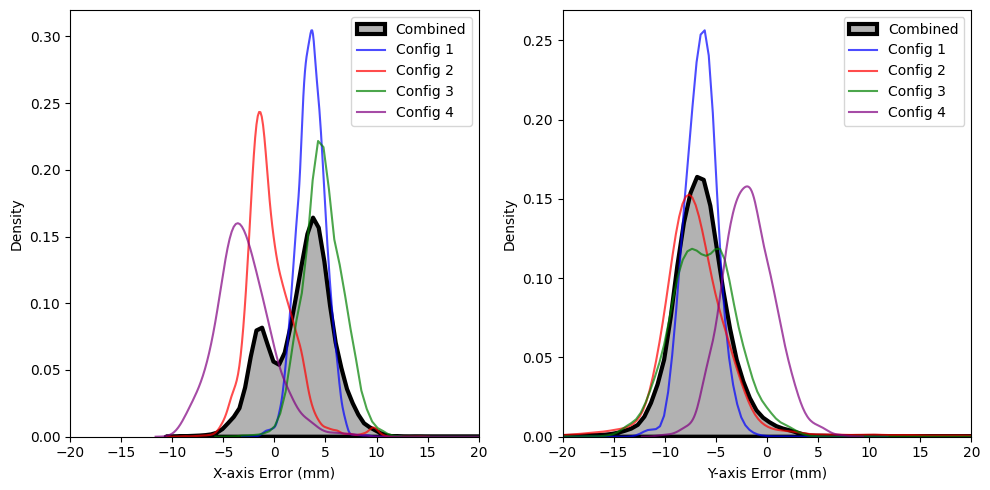

In [ ]:
# 2. Error Distribution Plot
plt.figure(figsize=(10, 5))

# Combine all errors
all_error_x = np.concatenate([
    (df['ft_x'] - df['opti_x']) * 1000 for df in [df1, df2, df3, df4]
])
all_error_y = np.concatenate([
    (df['ft_y'] - df['opti_y']) * 1000 for df in [df1, df2, df3, df4]
])

plt.subplot(1, 2, 1)
# Plot combined distribution first (so it's in the background)
sns.kdeplot(all_error_x, color='black', label='Combined', linewidth=3, alpha=0.3, fill=True)
# Plot individual distributions
for (name, df), color in zip(datasets.items(), colors):
    error_x = (df['ft_x'] - df['opti_x']) * 1000
    sns.kdeplot(error_x, color=color, label=name, alpha=0.7)
#plt.title('X-axis Error Distribution')
plt.xlabel('X-axis Error (mm)', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.legend(fontsize=14)
plt.xlim(-20, 20)

plt.subplot(1, 2, 2)
# Plot combined distribution first
sns.kdeplot(all_error_y, color='black', label='Combined', linewidth=3, alpha=0.3, fill=True)
# Plot individual distributions
for (name, df), color in zip(datasets.items(), colors):
    error_y = (df['ft_y'] - df['opti_y']) * 1000
    sns.kdeplot(error_y, color=color, label=name, alpha=0.7)
#plt.title('Y-axis Error Distribution')
plt.xlabel('Y-axis Error (mm)')
plt.legend()
plt.xlim(-20, 20)

plt.tight_layout()
plt.savefig('../../img/error_distribution.png', dpi=600, bbox_inches='tight', format='png')
plt.show()

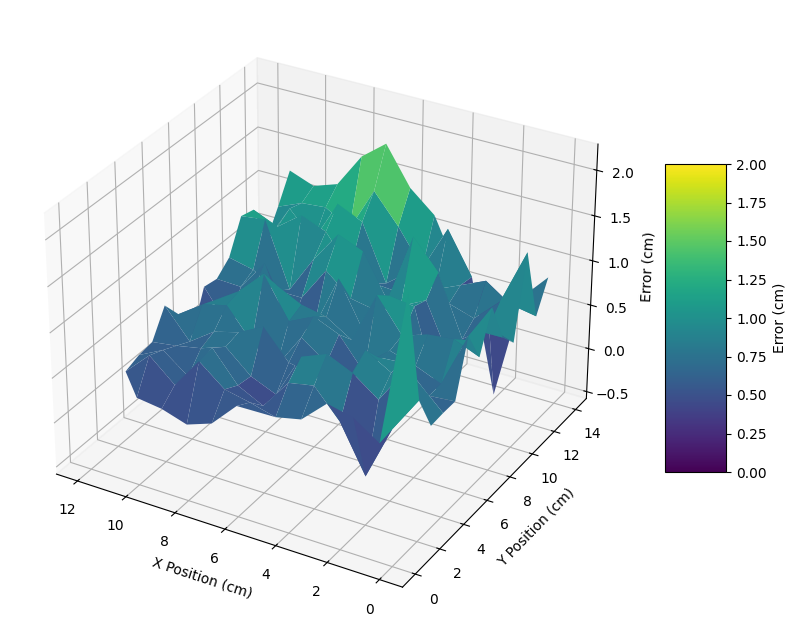

In [198]:
def plot_combined_error_surface(datasets, grid_size, max_error=3):
    # Combine all data points and errors
    all_x = np.concatenate([df['opti_x']*100 for df in datasets.values()])  # convert to cm
    all_y = np.concatenate([df['opti_y']*100 for df in datasets.values()])
    
    # Calculate error norms in centimeters for all points
    all_errors_x = np.concatenate([(df['ft_x'] - df['opti_x'])*100 for df in datasets.values()])
    all_errors_y = np.concatenate([(df['ft_y'] - df['opti_y'])*100 for df in datasets.values()])
    all_error_norm = np.sqrt(all_errors_x**2 + all_errors_y**2)
    
    # Filter out points with error > max_error
    mask = all_error_norm <= max_error
    all_x = all_x[mask]
    all_y = all_y[mask]
    all_error_norm = all_error_norm[mask]
    
    # Create grid
    xi = np.linspace(0, grid_size[0], grid_size[0]+1)  # 12 cm (pad width)
    yi = np.linspace(0, grid_size[1], grid_size[1]+1)  # 14 cm (pad height)
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate errors onto regular grid
    zi = griddata((all_x, all_y), 
                  all_error_norm, 
                  (xi, yi), 
                  method='cubic',
                  fill_value=np.nan)
    
    # Create the 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    surf = ax.plot_surface(xi, yi, zi, 
                          cmap='viridis',
                          linewidth=0,
                          antialiased=True,
                          vmin=0,  # set minimum of colorbar to 0
                          vmax=max_error)  # set maximum of colorbar to max_error
    
    # Add color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Error (cm)')
    
    # Labels and title
    ax.set_xlabel('X Position (cm)')
    ax.set_ylabel('Y Position (cm)')
    ax.set_zlabel('Error (cm)')
    #ax.set_title("Error Surface")
    
    # Invert axes if needed
    ax.invert_xaxis()
    
    return fig, ax

# Create and show the combined plot
grid_size = (12, 14)
fig, ax = plot_combined_error_surface(datasets, grid_size, max_error=2)
fig.savefig('../../img/error_surface.png', dpi=600, bbox_inches='tight', format='png')
plt.show()

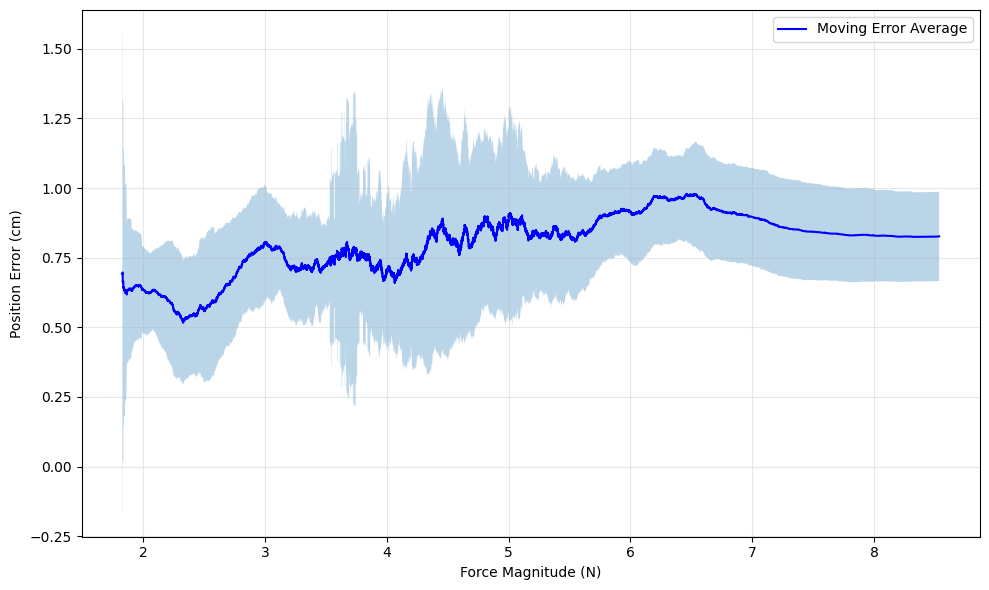

In [200]:
# Combine all datasets and calculate force magnitude and errors
combined_data = pd.DataFrame()

for name, df in datasets.items():
   temp_df = pd.DataFrame()
   
   # Calculate force magnitude
   temp_df['force_magnitude'] = np.sqrt(df['ft_force_x']**2 + df['ft_force_y']**2 + df['ft_force_z']**2)
   
   # Calculate position errors in cm
   error_x = (df['ft_x'] - df['opti_x']) * 100
   error_y = (df['ft_y'] - df['opti_y']) * 100
   temp_df['error_norm'] = np.sqrt(error_x**2 + error_y**2)
   
   combined_data = pd.concat([combined_data, temp_df])

# Sort by force magnitude
df_sorted = combined_data.sort_values('force_magnitude')

# Create figure
plt.figure(figsize=(10, 6))

# Moving average of error vs force magnitude
window_size = len(df_sorted) // 100  # Use 1% of data points as window
rolling_mean = df_sorted['error_norm'].rolling(window=window_size).mean()
rolling_std = df_sorted['error_norm'].rolling(window=window_size).std()

plt.plot(df_sorted['force_magnitude'], rolling_mean, 'b-', 
        label='Moving Error Average')
plt.fill_between(df_sorted['force_magnitude'],
                rolling_mean - rolling_std,
                rolling_mean + rolling_std,
                alpha=0.3)
plt.xlabel('Force Magnitude (N)')
plt.ylabel('Position Error (cm)')
#plt.title('Moving Error Average vs Force')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('../../img/force_error.png', dpi=600, bbox_inches='tight', format='png')
plt.show()


In [144]:
# 3. Calculate and print statistics for each dataset plus combined
print("\nError Statistics (in mm):")

# First print individual statistics
for name, df in datasets.items():
   error_x = (df['ft_x'] - df['opti_x']) * 1000
   error_y = (df['ft_y'] - df['opti_y']) * 1000
   error_norm = np.sqrt(error_x**2 + error_y**2)
   
   rmse_x = np.sqrt(np.mean(error_x**2))
   rmse_y = np.sqrt(np.mean(error_y**2))
   
   print(f"\n{name}:")
   print(f"Samples: {len(df)}")
   print(f"RMSE X: {rmse_x:.2f}")
   print(f"RMSE Y: {rmse_y:.2f}")
   print(f"Mean Error Norm: {np.mean(error_norm):.2f}")
   print(f"Std Error Norm: {np.std(error_norm):.2f}")
   print(f"Max Error: {np.max(error_norm):.2f}")

# Calculate and print combined statistics
all_error_x = np.concatenate([
   (df['ft_x'] - df['opti_x']) * 1000 for df in datasets.values()
])
all_error_y = np.concatenate([
   (df['ft_y'] - df['opti_y']) * 1000 for df in datasets.values()
])
all_error_norm = np.sqrt(all_error_x**2 + all_error_y**2)

print("\nCombined:")
print(f"Total Samples: {len(all_error_x)}")
print(f"RMSE X: {np.sqrt(np.mean(all_error_x**2)):.2f}")
print(f"RMSE Y: {np.sqrt(np.mean(all_error_y**2)):.2f}")
print(f"Mean Error Norm: {np.mean(all_error_norm):.2f}")
print(f"Std Error Norm: {np.std(all_error_norm):.2f}")
print(f"Max Error: {np.max(all_error_norm):.2f}")


Error Statistics (in mm):

Config 1:
Samples: 11591
RMSE X: 3.85
RMSE Y: 7.06
Mean Error Norm: 7.64
Std Error Norm: 2.51
Max Error: 66.60

Config 2:
Samples: 11947
RMSE X: 2.32
RMSE Y: 8.32
Mean Error Norm: 7.86
Std Error Norm: 3.58
Max Error: 32.40

Config 3:
Samples: 11859
RMSE X: 5.29
RMSE Y: 7.00
Mean Error Norm: 8.25
Std Error Norm: 2.99
Max Error: 112.62

Config 4:
Samples: 657
RMSE X: 4.11
RMSE Y: 3.06
Mean Error Norm: 4.68
Std Error Norm: 2.10
Max Error: 26.24

Combined:
Total Samples: 36054
RMSE X: 4.01
RMSE Y: 7.43
Mean Error Norm: 7.86
Std Error Norm: 3.09
Max Error: 112.62


## Dynamic Case

### Translation

In [161]:
# Load the translation data
data_dyn = {
    'X': {
        'high': pd.read_csv(base_path/'data_dyn_x_high.csv'),
        'mid': pd.read_csv(base_path/'data_dyn_x_mid.csv'),
        'low': pd.read_csv(base_path/'data_dyn_x_low.csv')
    },
    'Y': {
        'high': pd.read_csv(base_path/'data_dyn_y_high.csv'),
        'mid': pd.read_csv(base_path/'data_dyn_y_mid.csv'),
        'low': pd.read_csv(base_path/'data_dyn_y_low.csv')
    },
    'Z': {
        'high': pd.read_csv(base_path/'data_dyn_z_high.csv'),
        'mid': pd.read_csv(base_path/'data_dyn_z_mid.csv'),
        'low': pd.read_csv(base_path/'data_dyn_z_low.csv')
    },
    'XYZ': {
        'high': pd.read_csv(base_path/'data_dyn_xyz_high.csv'),
        'mid': pd.read_csv(base_path/'data_dyn_xyz_mid.csv'),
        'low': pd.read_csv(base_path/'data_dyn_xyz_low.csv')
    }
}

for axis in data_dyn:
    for speed in data_dyn[axis]:
        data_dyn[axis][speed].drop(data_dyn[axis][speed][(data_dyn[axis][speed]['ft_x'] == 0) & (data_dyn[axis][speed]['ft_y'] == 0)].index, inplace=True)
        # Create mask for values within [-0.2, 0.2]
        mask = (data_dyn[axis][speed]['ft_x'].between(-0.2, 0.2)) & \
               (data_dyn[axis][speed]['ft_y'].between(-0.2, 0.2)) & \
               (data_dyn[axis][speed]['opti_x'].between(-0.2, 0.2)) & \
               (data_dyn[axis][speed]['opti_y'].between(-0.2, 0.2))
        
        # Apply filter
        data_dyn[axis][speed] = data_dyn[axis][speed][mask]



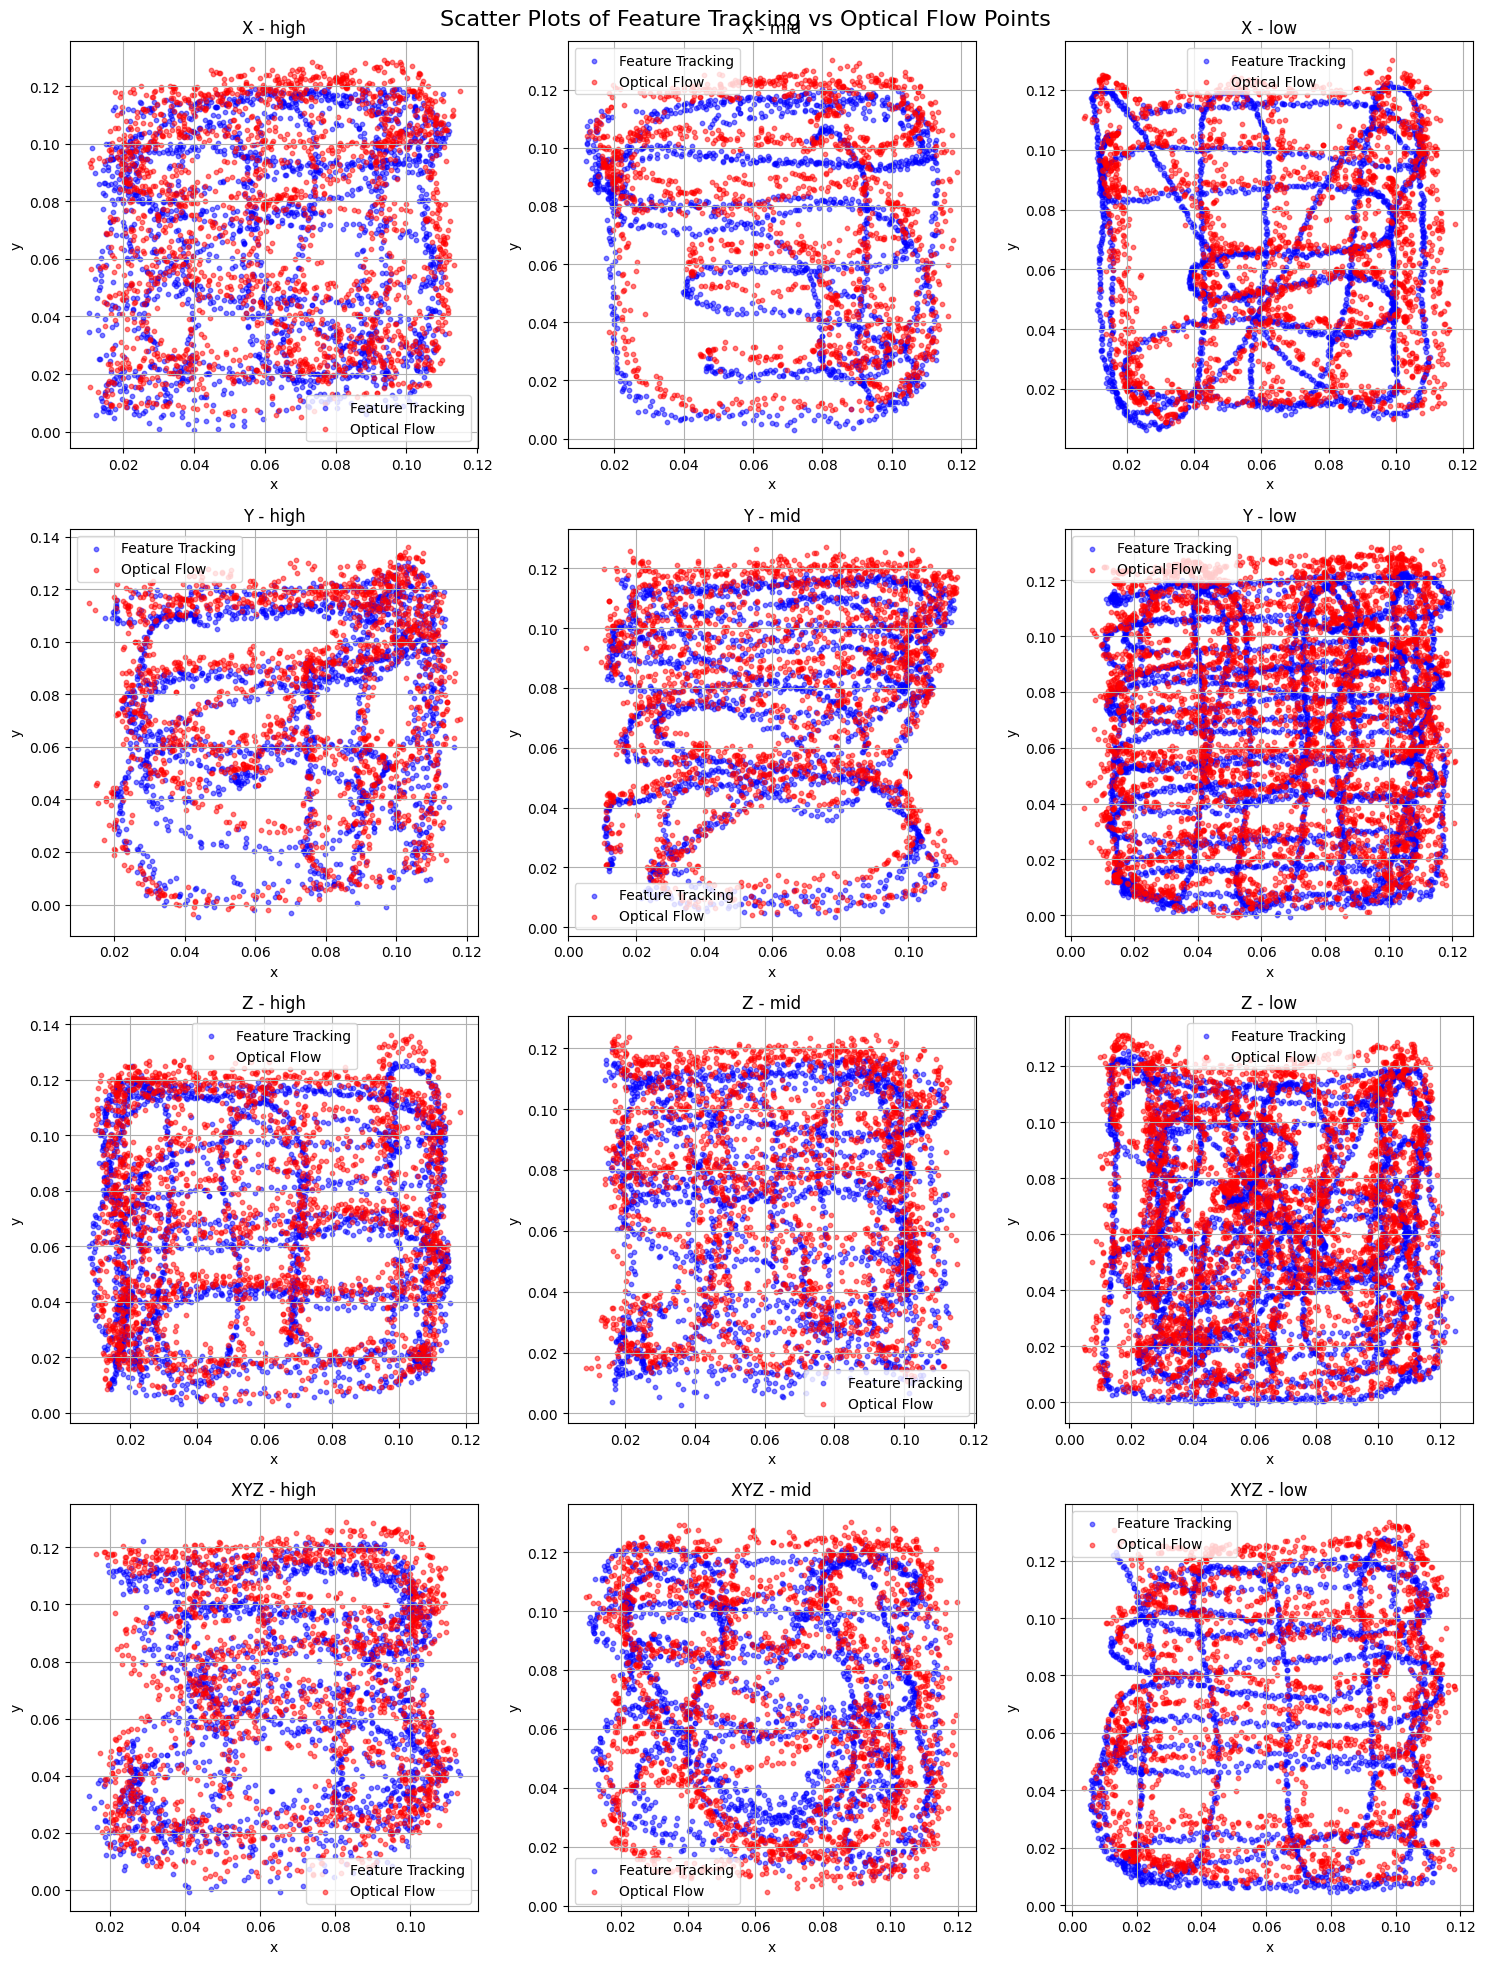

In [162]:
# Create a figure with subplots for each axis
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
fig.suptitle('Scatter Plots of Feature Tracking vs Optical Flow Points', fontsize=16)

# Dictionary to map speeds to columns
speeds = ['high', 'mid', 'low']
axes = ['X', 'Y', 'Z', 'XYZ']

# Create scatter plots
for i, axis in enumerate(axes):
    for j, speed in enumerate(speeds):
        df = data_dyn[axis][speed]
        
        # Plot feature tracking points in blue
        axs[i, j].scatter(df['ft_x'], df['ft_y'], alpha=0.5, s=10, color='blue', label='Feature Tracking')
        
        # Plot optical flow points in red
        axs[i, j].scatter(df['opti_x'], df['opti_y'], alpha=0.5, s=10, color='red', label='Optical Flow')
        
        axs[i, j].set_title(f'{axis} - {speed}')
        axs[i, j].set_xlabel('x')
        axs[i, j].set_ylabel('y')
        axs[i, j].grid(True)
        axs[i, j].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


X Movement Statistics (mm):

high:
Mean: 6.80 mm
Median: 6.47 mm
Std: 4.35 mm
Q1: 4.65 mm
Q3: 8.46 mm

mid:
Mean: 7.11 mm
Median: 7.07 mm
Std: 2.39 mm
Q1: 5.48 mm
Q3: 8.73 mm

low:
Mean: 4.96 mm
Median: 4.86 mm
Std: 1.93 mm
Q1: 3.66 mm
Q3: 6.15 mm

Y Movement Statistics (mm):

high:
Mean: 5.86 mm
Median: 5.66 mm
Std: 2.80 mm
Q1: 3.86 mm
Q3: 7.66 mm

mid:
Mean: 5.29 mm
Median: 5.16 mm
Std: 2.42 mm
Q1: 3.50 mm
Q3: 6.77 mm

low:
Mean: 5.59 mm
Median: 5.33 mm
Std: 3.61 mm
Q1: 3.77 mm
Q3: 6.99 mm

Z Movement Statistics (mm):

high:
Mean: 5.01 mm
Median: 4.82 mm
Std: 2.34 mm
Q1: 3.37 mm
Q3: 6.45 mm

mid:
Mean: 5.99 mm
Median: 5.93 mm
Std: 2.43 mm
Q1: 4.25 mm
Q3: 7.64 mm

low:
Mean: 5.35 mm
Median: 5.13 mm
Std: 3.31 mm
Q1: 3.54 mm
Q3: 6.74 mm

XYZ Movement Statistics (mm):

high:
Mean: 6.67 mm
Median: 6.12 mm
Std: 3.94 mm
Q1: 4.18 mm
Q3: 8.55 mm

mid:
Mean: 7.61 mm
Median: 6.54 mm
Std: 7.14 mm
Q1: 4.53 mm
Q3: 9.49 mm

low:
Mean: 6.65 mm
Median: 6.60 mm
Std: 3.05 mm
Q1: 5.05 mm
Q3: 8.09 mm


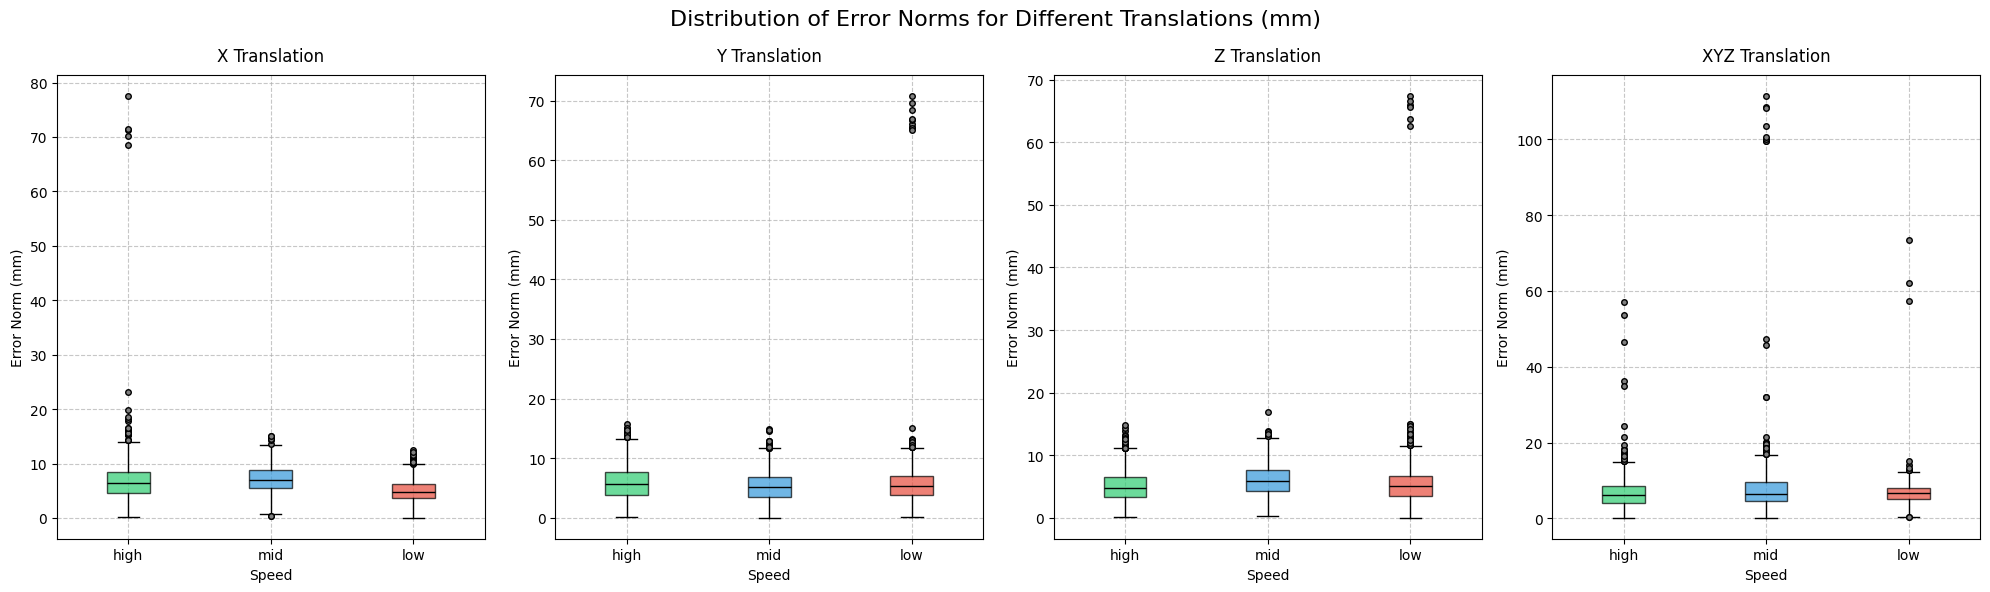

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# Conversion factor from meters to millimeters
M_TO_MM = 1000

# Set figure style
plt.style.use('default')
fig, axs = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('Distribution of Error Norms for Different Translations (mm)', fontsize=16)

# Custom colors for each speed
colors = ['#2ecc71', '#3498db', '#e74c3c']  # green, blue, red

# Process each movement type
for idx, axis in enumerate(['X', 'Y', 'Z', 'XYZ']):
    # Collect error norms for each speed
    error_data = []
    labels = []
    
    for speed in speeds:
        df = data_dyn[axis][speed]
        # Calculate error as difference between filtered and optical measurements
        error_x = df['ft_x'] - df['opti_x']
        error_y = df['ft_y'] - df['opti_y']
        
        # Calculate error norms and convert to millimeters
        error_norms = np.sqrt(error_x**2 + error_y**2) * M_TO_MM
        error_data.append(error_norms)
        labels.append(speed)
    
    # Create box plot
    bp = axs[idx].boxplot(error_data, 
                         labels=labels,
                         patch_artist=True,  # Fill boxes with color
                         medianprops={'color': 'black'},  # Black median lines
                         flierprops={'marker': 'o', 'markerfacecolor': 'gray', 'markersize': 4})  # Outlier style
    
    # Set box colors
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Customize plot
    axs[idx].set_title(f'{axis} Translation', fontsize=12, pad=10)
    axs[idx].set_xlabel('Speed', fontsize=10)
    axs[idx].set_ylabel('Error Norm (mm)', fontsize=10)
    axs[idx].grid(True, linestyle='--', alpha=0.7)
    
    # Print summary statistics
    print(f"\n{axis} Movement Statistics (mm):")
    for speed, errors in zip(speeds, error_data):
        print(f"\n{speed}:")
        print(f"Mean: {np.mean(errors):.2f} mm")
        print(f"Median: {np.median(errors):.2f} mm")
        print(f"Std: {np.std(errors):.2f} mm")
        print(f"Q1: {np.percentile(errors, 25):.2f} mm")
        print(f"Q3: {np.percentile(errors, 75):.2f} mm")

plt.tight_layout()
plt.show()

### Rotation

In [164]:
# Load the translation data
data_dyn = {
    'X': {
        'high': pd.read_csv(base_path/'data_dyn_orientation_x_high.csv'),
        'mid': pd.read_csv(base_path/'data_dyn_orientation_x_mid.csv'),
        'low': pd.read_csv(base_path/'data_dyn_orientation_x_low.csv')
    },
    'Y': {
        'high': pd.read_csv(base_path/'data_dyn_orientation_y_high.csv'),
        'mid': pd.read_csv(base_path/'data_dyn_orientation_y_mid.csv'),
        'low': pd.read_csv(base_path/'data_dyn_orientation_y_low.csv')
    },
    'XY': {
        'high': pd.read_csv(base_path/'data_dyn_orientation_xy_high.csv'),
        'mid': pd.read_csv(base_path/'data_dyn_orientation_xy_mid.csv'),
        'low': pd.read_csv(base_path/'data_dyn_orientation_xy_low.csv')
    },
}

for axis in data_dyn:
    for speed in data_dyn[axis]:
        data_dyn[axis][speed].drop(data_dyn[axis][speed][(data_dyn[axis][speed]['ft_x'] == 0) & (data_dyn[axis][speed]['ft_y'] == 0)].index, inplace=True)
        # Create mask for values within [-0.2, 0.2]
        mask = (data_dyn[axis][speed]['ft_x'].between(-0.05, 0.15)) & \
               (data_dyn[axis][speed]['ft_y'].between(-0.05, 0.15)) & \
               (data_dyn[axis][speed]['opti_x'].between(-0.05, 0.15)) & \
               (data_dyn[axis][speed]['opti_y'].between(-0.05, 0.15))
        
        # Apply filter
        data_dyn[axis][speed] = data_dyn[axis][speed][mask]


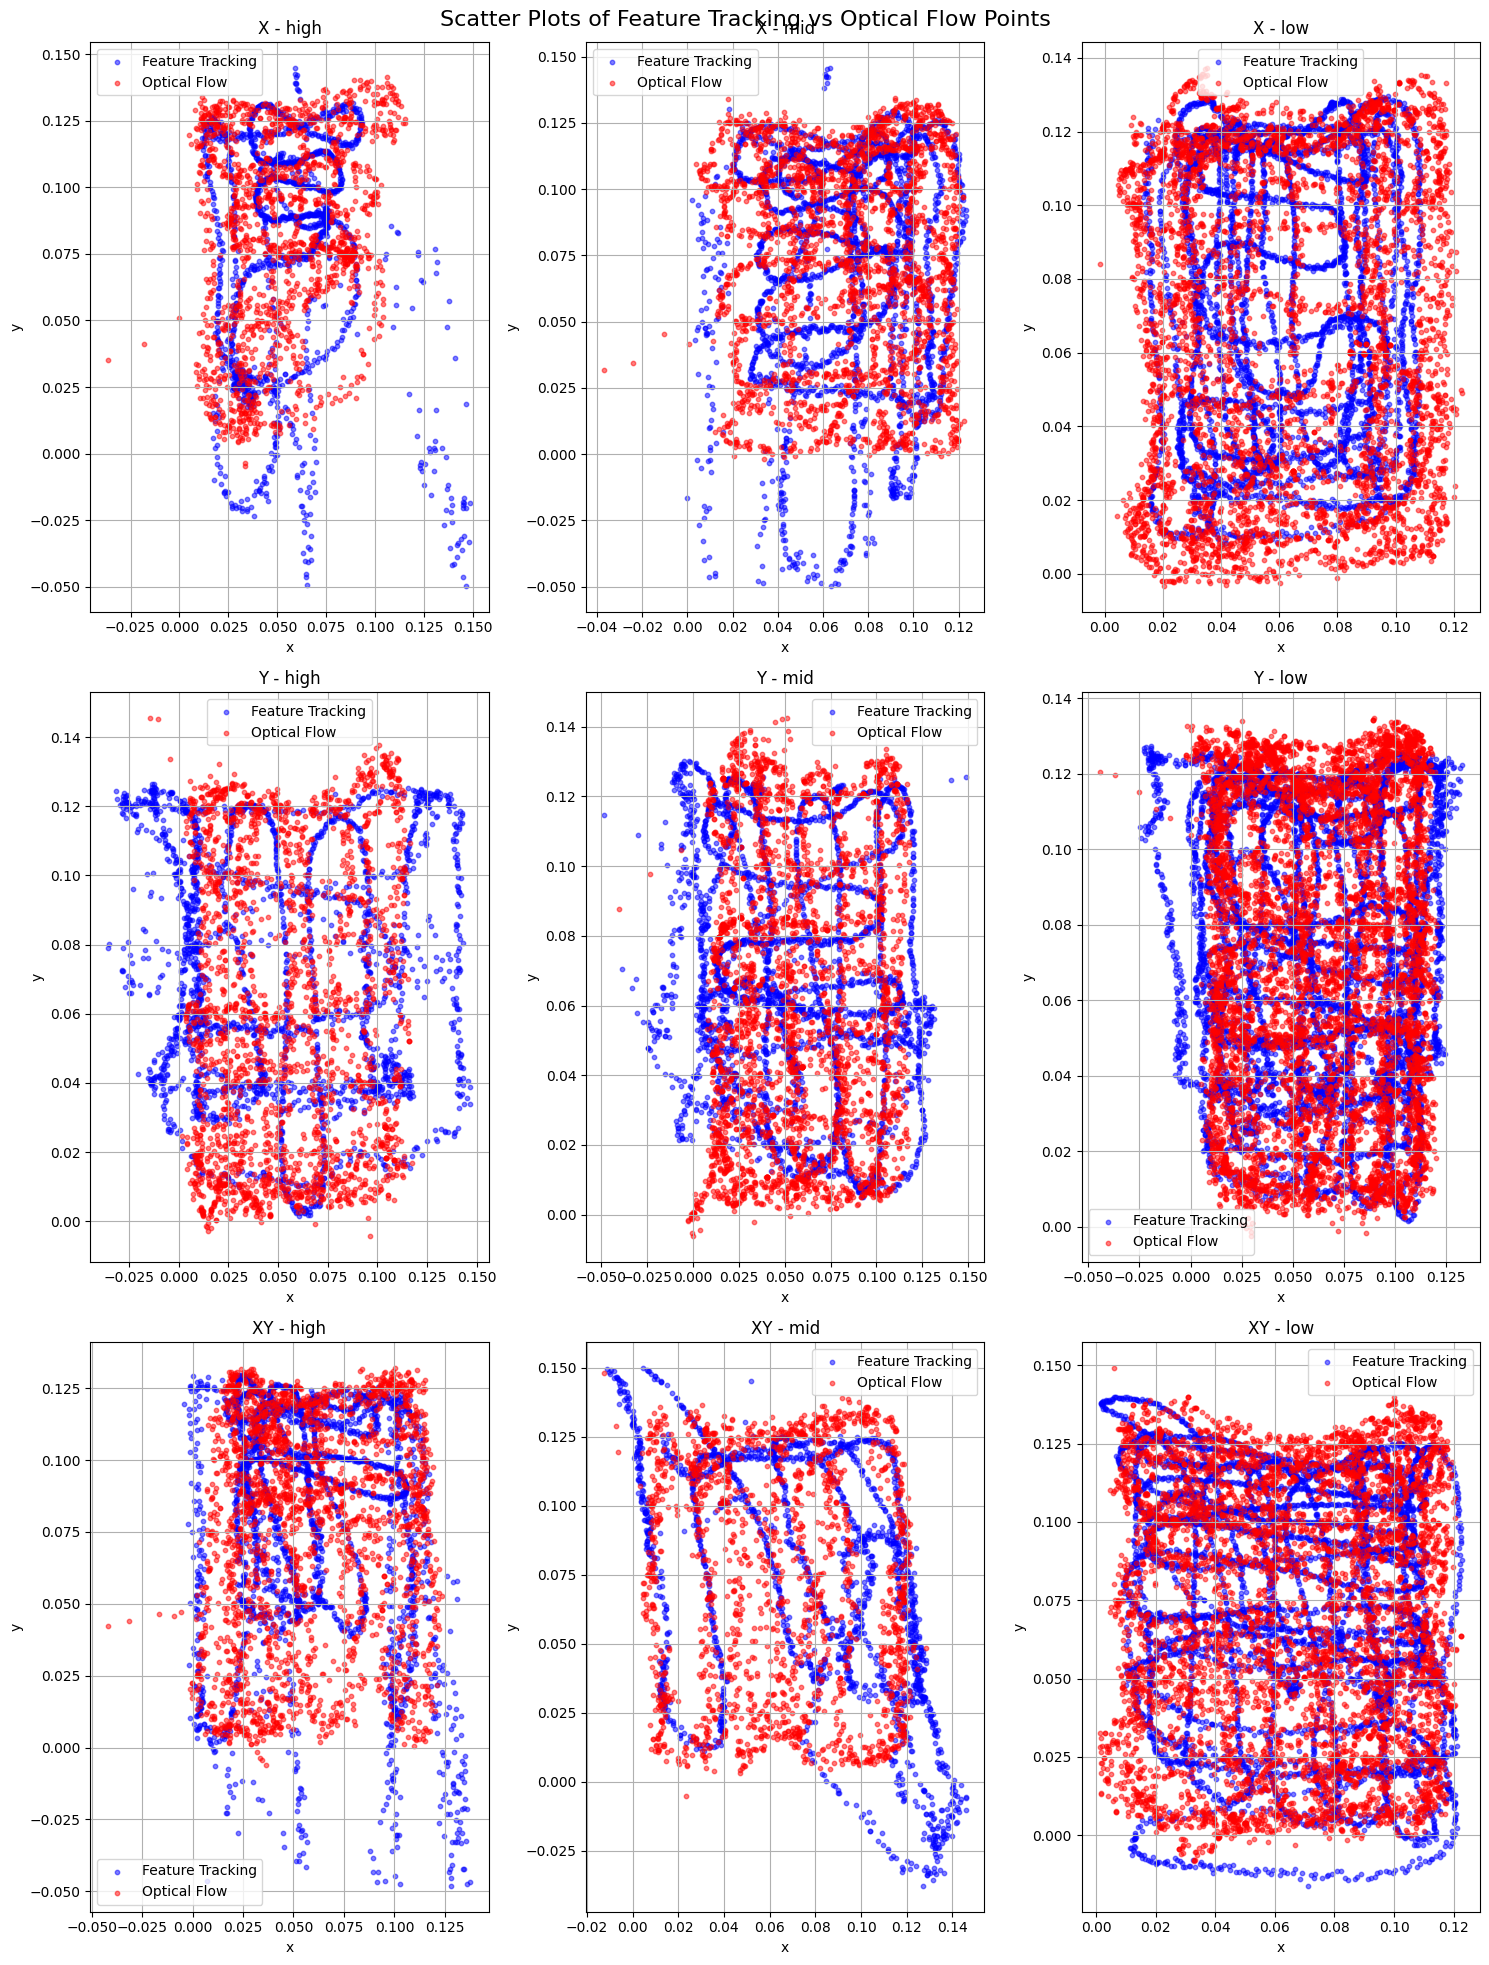

In [157]:
# Create a figure with subplots for each axis
fig, axs = plt.subplots(3, 3, figsize=(15, 20))
fig.suptitle('Scatter Plots of Feature Tracking vs Optical Flow Points', fontsize=16)

# Dictionary to map speeds to columns
speeds = ['high', 'mid', 'low']
axes = ['X', 'Y', 'XY']

# Create scatter plots
for i, axis in enumerate(axes):
    for j, speed in enumerate(speeds):
        df = data_dyn[axis][speed]
        
        # Plot feature tracking points in blue
        axs[i, j].scatter(df['ft_x'], df['ft_y'], alpha=0.5, s=10, color='blue', label='Feature Tracking')
        
        # Plot optical flow points in red
        axs[i, j].scatter(df['opti_x'], df['opti_y'], alpha=0.5, s=10, color='red', label='Optical Flow')
        
        axs[i, j].set_title(f'{axis} - {speed}')
        axs[i, j].set_xlabel('x')
        axs[i, j].set_ylabel('y')
        axs[i, j].grid(True)
        axs[i, j].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


X Movement Statistics (mm):

high:
Mean: 20.88 mm
Median: 14.99 mm
Std: 23.54 mm
Q1: 9.34 mm
Q3: 20.09 mm

mid:
Mean: 19.34 mm
Median: 14.65 mm
Std: 18.84 mm
Q1: 8.23 mm
Q3: 21.07 mm

low:
Mean: 13.01 mm
Median: 12.00 mm
Std: 7.64 mm
Q1: 6.91 mm
Q3: 18.23 mm

Y Movement Statistics (mm):

high:
Mean: 21.28 mm
Median: 18.51 mm
Std: 16.81 mm
Q1: 7.43 mm
Q3: 29.71 mm

mid:
Mean: 17.73 mm
Median: 12.07 mm
Std: 19.58 mm
Q1: 6.55 mm
Q3: 23.49 mm

low:
Mean: 11.05 mm
Median: 8.09 mm
Std: 9.99 mm
Q1: 5.36 mm
Q3: 12.84 mm

XY Movement Statistics (mm):

high:
Mean: 22.37 mm
Median: 14.53 mm
Std: 21.42 mm
Q1: 8.34 mm
Q3: 30.71 mm

mid:
Mean: 21.67 mm
Median: 15.94 mm
Std: 17.18 mm
Q1: 9.57 mm
Q3: 31.40 mm

low:
Mean: 12.04 mm
Median: 7.90 mm
Std: 18.12 mm
Q1: 4.89 mm
Q3: 12.14 mm


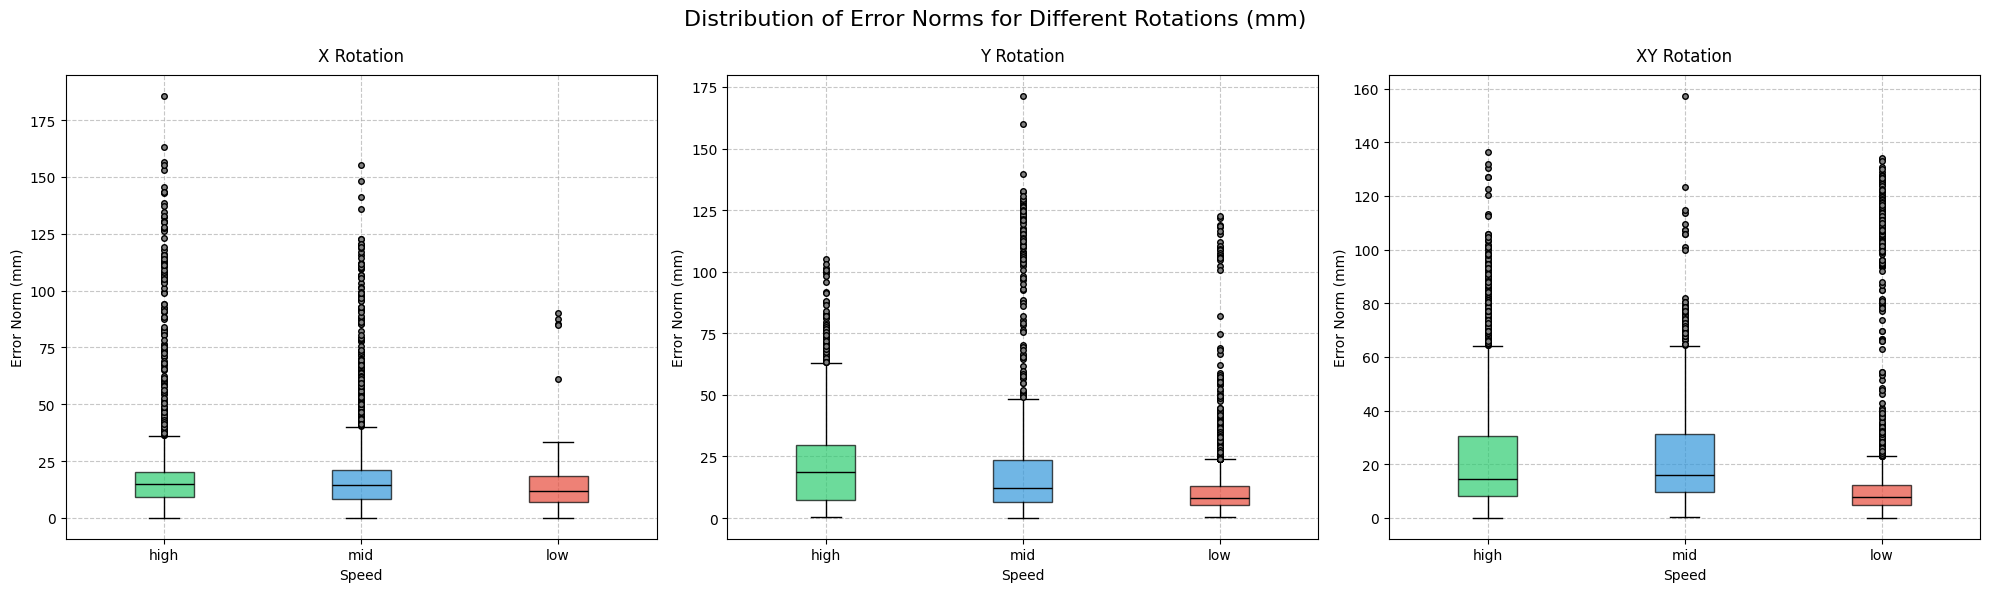

In [ ]:
# Conversion factor from meters to millimeters
M_TO_MM = 1000

# Set figure style
plt.style.use('default')
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribution of Error Norms for Different Rotations (mm)', fontsize=16)

# Custom colors for each speed
colors = ['#2ecc71', '#3498db', '#e74c3c']  # green, blue, red

# Process each movement type
for idx, axis in enumerate(['X', 'Y', 'XY']):
    # Collect error norms for each speed
    error_data = []
    labels = []
    
    for speed in speeds:
        df = data_dyn[axis][speed]
        # Calculate error as difference between filtered and optical measurements
        error_x = df['ft_x'] - df['opti_x']
        error_y = df['ft_y'] - df['opti_y']
        
        # Calculate error norms and convert to millimeters
        error_norms = np.sqrt(error_x**2 + error_y**2) * M_TO_MM
        error_data.append(error_norms)
        labels.append(speed)
    
    # Create box plot
    bp = axs[idx].boxplot(error_data, 
                         labels=labels,
                         patch_artist=True,  # Fill boxes with color
                         medianprops={'color': 'black'},  # Black median lines
                         flierprops={'marker': 'o', 'markerfacecolor': 'gray', 'markersize': 4})  # Outlier style
    
    # Set box colors
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Customize plot
    axs[idx].set_title(f'{axis} Rotation', fontsize=12, pad=10)
    axs[idx].set_xlabel('Speed', fontsize=10)
    axs[idx].set_ylabel('Error Norm (mm)', fontsize=10)
    axs[idx].grid(True, linestyle='--', alpha=0.7)
    
    # Print summary statistics
    print(f"\n{axis} Movement Statistics (mm):")
    for speed, errors in zip(speeds, error_data):
        print(f"\n{speed}:")
        print(f"Mean: {np.mean(errors):.2f} mm")
        print(f"Median: {np.median(errors):.2f} mm")
        print(f"Std: {np.std(errors):.2f} mm")
        print(f"Q1: {np.percentile(errors, 25):.2f} mm")
        print(f"Q3: {np.percentile(errors, 75):.2f} mm")

plt.tight_layout()
plt.show()

## Two Payloads

In [187]:
df = pd.read_csv(base_path/'data_two_payloads_ft.csv')

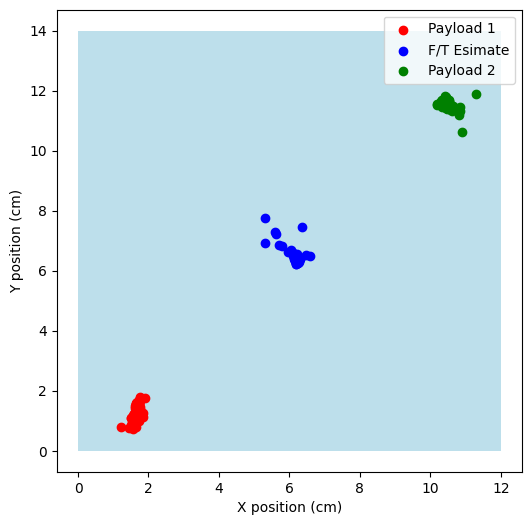

In [188]:
# Define individual masks for each case
mask1 = (df['ft_x'] >= 0.01) & (df['ft_x'] <= 0.02) & (df['ft_y'] >= 0.00) & (df['ft_y'] <= 0.02)
mask2 = (df['ft_x'] >= 0.05) & (df['ft_x'] <= 0.07) & (df['ft_y'] >= 0.05) & (df['ft_y'] <= 0.08)
mask3 = (df['ft_x'] >= 0.10) & (df['ft_x'] <= 0.12) & (df['ft_y'] >= 0.10) & (df['ft_y'] <= 0.12)
df['ft_x'] = df['ft_x'] * 100
df['ft_y'] = df['ft_y'] * 100
# Filter the data
df_case1 = df[mask1]
df_case2 = df[mask2]
df_case3 = df[mask3]

# Plot the cases with different colors
plt.figure(figsize=(6, 6))
pad = plt.Rectangle((0, 0), 12, 14, facecolor='lightblue', alpha=0.8)
plt.gca().add_patch(pad)
plt.scatter(df_case1['ft_x'], df_case1['ft_y'], color='red', label='Payload 1')
plt.scatter(df_case2['ft_x'], df_case2['ft_y'], color='blue', label='F/T Esimate')
plt.scatter(df_case3['ft_x'], df_case3['ft_y'], color='green', label='Payload 2')
plt.xlabel('X position (cm)')
plt.ylabel('Y position (cm)')
plt.legend()
plt.grid(False)
plt.show()
